In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

In [5]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
)  

In [6]:
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

# Abortion    

In [117]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [118]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [ ]:
active_mc_abortion1= []
query_history = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        num = num+20
        print(num)
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_abortion)
    print(query)
    active_mc_abortion1.append(performance_history_abortion)
    query_history.append(query)
    mcrun = mcrun + 1

In [119]:
active_mc_abortion1= []
query_history = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        num = num+20
        print(num)
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_abortion)
    print(query)
    active_mc_abortion1.append(performance_history_abortion)
    query_history.append(query)
    mcrun = mcrun + 1

[ 36 198  92]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:02.293000Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 29.69it/s]


23


***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:06.991568Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 31.79it/s]


43


***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:11.561243Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.08it/s]


63


***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:16.243012Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.15it/s]


83


***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:20.973828Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.59it/s]


103


***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:25.923066Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.38it/s]


123


***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:31.255647Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.07it/s]


143


***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:36.460155Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.29it/s]


163


***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:42.151012Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.83it/s]


183


***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:47.882349Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.95it/s]


203


***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:53.848038Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.76it/s]


223


***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:26:59.929320Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.33it/s]


243


***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:06.114671Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.63it/s]


263


***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:12.542783Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.81it/s]


283


***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:19.254052Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.66it/s]


303


***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:26.020487Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.75it/s]


323


***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:32.983793Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.60it/s]


343


***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:40.490740Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.53it/s]


363


***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:47.812090Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.62it/s]


383


***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:27:55.343958Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.18it/s]


403


***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:02.941414Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.15it/s]


423


***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:10.771061Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.17it/s]


443


***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:19.134897Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.08it/s]


463


***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:27.254016Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31.48it/s]


483


***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:36.030194Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.15it/s]


503


***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:44.594009Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.40it/s]


523


***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:28:53.095312Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.11it/s]


543


***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:01.970515Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 34.42it/s]


563


***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:11.001801Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.19it/s]


583


***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:20.378910Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s]


603
[0.45357142857142857, 0.42142857142857143, 0.4785714285714286, 0.5178571428571429, 0.475, 0.45, 0.4857142857142857, 0.5178571428571429, 0.6142857142857143, 0.575, 0.6, 0.5964285714285714, 0.6321428571428571, 0.6071428571428571, 0.6642857142857143, 0.6642857142857143, 0.6535714285714286, 0.65, 0.6678571428571428, 0.6607142857142857, 0.6857142857142857, 0.6678571428571428, 0.6714285714285714, 0.6714285714285714, 0.6714285714285714, 0.6714285714285714, 0.6571428571428571, 0.6785714285714286, 0.675, 0.6642857142857143, 0.6678571428571428]
[3, 23, 43, 63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:23.901593Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 31.86it/s]


23


***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:28.278245Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.89it/s]


43


***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:32.760080Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.24it/s]


63


***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:37.330423Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.63it/s]


83


***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:42.172539Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.90it/s]


103


***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:47.112852Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.55it/s]


123


***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:52.620039Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.53it/s]


143


***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:29:58.384761Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.79it/s]


163


***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:03.999486Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.72it/s]


183


***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:09.652796Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.19it/s]


203


***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:15.698795Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.08it/s]


223


***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:21.796952Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.32it/s]


243


***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:28.075735Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.98it/s]


263


***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:34.755921Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.55it/s]


283


***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:41.385860Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 31.41it/s]


303


***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:48.202306Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.14it/s]


323


***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:30:55.241198Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.07it/s]


343


***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:02.497466Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.07it/s]


363


***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:09.760694Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.78it/s]


383


***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:17.176934Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.79it/s]


403


***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:24.772298Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.97it/s]


423


***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:32.454084Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.10it/s]


443


***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:40.618049Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.60it/s]


463


***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:48.815221Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.95it/s]


483


***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:31:57.160338Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.24it/s]


503


***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:05.442925Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.37it/s]


523


***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:14.173328Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.45it/s]


543


***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:22.853773Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.81it/s]


563


***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:31.849658Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.22it/s]


583


***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:41.363112Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s]


603
[0.4607142857142857, 0.4392857142857143, 0.5142857142857142, 0.5678571428571428, 0.5178571428571429, 0.5928571428571429, 0.5464285714285714, 0.5964285714285714, 0.6142857142857143, 0.5964285714285714, 0.6285714285714286, 0.6357142857142857, 0.6428571428571429, 0.6392857142857142, 0.6464285714285715, 0.6785714285714286, 0.6571428571428571, 0.6535714285714286, 0.6714285714285714, 0.6678571428571428, 0.6821428571428572, 0.6607142857142857, 0.6571428571428571, 0.6642857142857143, 0.6714285714285714, 0.6607142857142857, 0.675, 0.6571428571428571, 0.675, 0.6678571428571428, 0.6642857142857143]
[3, 23, 43, 63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:44.845277Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.78it/s]


23


***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:48.994948Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.55it/s]


43


***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:53.380914Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.00it/s]


63


***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:32:57.929361Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.25it/s]


83


***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:02.961095Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.21it/s]


103


***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:07.992647Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.64it/s]


123


***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:13.091988Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.81it/s]


143


***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:18.304850Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.17it/s]


163


***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:23.899802Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.07it/s]


183


***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:29.630196Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 34.12it/s]


203


***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:35.544833Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.96it/s]


223


***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:41.709453Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.87it/s]


243


***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:48.057293Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.65it/s]


263


***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:33:54.310414Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.31it/s]


283


***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:00.903995Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.89it/s]


303


***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:07.817341Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.49it/s]


323


***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:14.835790Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.05it/s]


343


***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:22.030432Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.21it/s]


363


***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:29.228816Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.95it/s]


383


***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:36.707558Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.61it/s]


403


***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:44.349825Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.00it/s]


423


***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:34:52.086702Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.04it/s]


443


***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:00.331977Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 30.77it/s]


463


***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:08.497848Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.35it/s]


483


***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:16.683629Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.11it/s]


503


***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:25.043300Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.97it/s]


523


***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:33.739304Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 28.27it/s]


543


***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:42.572793Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.00it/s]


563


***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:35:51.582274Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.15it/s]


583


***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:00.946873Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.50it/s]


603
[0.4607142857142857, 0.4392857142857143, 0.5142857142857142, 0.5678571428571428, 0.5178571428571429, 0.5928571428571429, 0.5464285714285714, 0.5964285714285714, 0.6142857142857143, 0.5964285714285714, 0.6285714285714286, 0.6357142857142857, 0.6428571428571429, 0.6392857142857142, 0.6464285714285715, 0.6785714285714286, 0.6571428571428571, 0.6535714285714286, 0.6714285714285714, 0.6678571428571428, 0.6821428571428572, 0.6607142857142857, 0.6571428571428571, 0.6642857142857143, 0.6714285714285714, 0.6607142857142857, 0.675, 0.6571428571428571, 0.675, 0.6678571428571428, 0.6642857142857143]
[3, 23, 43, 63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:04.386759Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.71it/s]


23


***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:08.597368Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.74it/s]


43


***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:12.997944Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.85it/s]


63


***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:17.563090Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.97it/s]


83


***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:22.411437Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.45it/s]


103


***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:27.362311Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.77it/s]


123


***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:32.735234Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.90it/s]


143


***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:38.088465Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.26it/s]


163


***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:43.660100Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.72it/s]


183


***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:49.462761Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.19it/s]


203


***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:36:55.381603Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.78it/s]


223


***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:01.442059Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.47it/s]


243


***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:07.724259Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.26it/s]


263


***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:14.322099Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.71it/s]


283


***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:21.069558Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.52it/s]


303


***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:28.016477Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.34it/s]


323


***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:35.102579Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 30.97it/s]


343


***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:42.229330Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.29it/s]


363


***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:49.375878Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.06it/s]


383


***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:37:56.728636Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.44it/s]


403


***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:04.293737Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.07it/s]


423


***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:12.102605Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.65it/s]


443


***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:20.472936Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.87it/s]


463


***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:28.662732Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.88it/s]


483


***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:36.915028Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 31.34it/s]


503


***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:45.391505Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.29it/s]


523


***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:38:53.970788Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.18it/s]


543


***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:02.801210Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.25it/s]


563


***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:11.689756Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.83it/s]


583


***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:20.896024Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


603
[0.4607142857142857, 0.4392857142857143, 0.5142857142857142, 0.5678571428571428, 0.5178571428571429, 0.5928571428571429, 0.5464285714285714, 0.5964285714285714, 0.6142857142857143, 0.5964285714285714, 0.6285714285714286, 0.6357142857142857, 0.6428571428571429, 0.6392857142857142, 0.6464285714285715, 0.6785714285714286, 0.6571428571428571, 0.6535714285714286, 0.6714285714285714, 0.6678571428571428, 0.6821428571428572, 0.6607142857142857, 0.6571428571428571, 0.6642857142857143, 0.6714285714285714, 0.6607142857142857, 0.675, 0.6571428571428571, 0.675, 0.6678571428571428, 0.6642857142857143]
[3, 23, 43, 63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:24.378219Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.85it/s]


23


***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:28.659061Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.76it/s]


43


***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:33.394946Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.13it/s]


63


***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:38.444265Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.02it/s]


83


***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:43.243713Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.57it/s]


103


***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:48.074372Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.08it/s]


123


***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:53.635115Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.38it/s]


143


***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:39:59.054011Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.42it/s]


163


***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:04.664686Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.69it/s]


183


***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:10.380423Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.93it/s]


203


***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:16.259943Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.91it/s]


223


***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:22.341025Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.62it/s]


243


***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:28.570072Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.09it/s]


263


***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:34.942922Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.84it/s]


283


***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:41.652193Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 31.44it/s]


303


***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:48.449851Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.82it/s]


323


***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:40:55.463135Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.51it/s]


343


***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:02.695104Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.79it/s]


363


***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:09.912442Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.41it/s]


383


***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:17.356850Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.88it/s]


403


***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:25.057325Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.34it/s]


423


***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:32.901542Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.04it/s]


443


***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:40.998796Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 30.86it/s]


463


***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:49.146039Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.29it/s]


483


***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:41:57.542257Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.81it/s]


503


***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:05.991396Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.79it/s]


523


***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:14.753098Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.71it/s]


543


***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:23.650099Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.79it/s]


563


***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:32.864597Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.26it/s]


583


***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:42.049017Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


603
[0.4607142857142857, 0.4392857142857143, 0.5142857142857142, 0.5678571428571428, 0.5178571428571429, 0.5928571428571429, 0.5464285714285714, 0.5964285714285714, 0.6142857142857143, 0.5964285714285714, 0.6285714285714286, 0.6357142857142857, 0.6428571428571429, 0.6392857142857142, 0.6464285714285715, 0.6785714285714286, 0.6571428571428571, 0.6535714285714286, 0.6714285714285714, 0.6678571428571428, 0.6821428571428572, 0.6607142857142857, 0.6571428571428571, 0.6642857142857143, 0.6714285714285714, 0.6607142857142857, 0.675, 0.6571428571428571, 0.675, 0.6678571428571428, 0.6642857142857143]
[3, 23, 43, 63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603]


In [120]:
median_abortion1, min_abortion1,max_abortion1 = calculate(active_mc_abortion1)

In [121]:
active_mc_abortion2= []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_abortion2 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 40, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        num = num + 40
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_abortion)
    active_mc_abortion2.append(performance_history_abortion)
    query_history_abortion2.append(query)
    mcrun = mcrun + 1

[488 442 472]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:45.626158Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.64it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:50.158776Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.60it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:42:55.223747Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:00.522996Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.22it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:06.260089Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.76it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:12.950159Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 31.53it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:19.282320Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.75it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:25.996720Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:32.944509Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.83it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:40.540752Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.89it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:48.194424Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.59it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:43:56.218823Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 32.21it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:06.047883Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:16.477606Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.50it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:25.410012Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.88it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.3964285714285714, 0.3821428571428571, 0.5464285714285714, 0.5964285714285714, 0.5678571428571428, 0.6464285714285715, 0.6142857142857143, 0.6321428571428571, 0.6571428571428571, 0.6607142857142857, 0.6428571428571429, 0.6678571428571428, 0.6642857142857143, 0.675, 0.6464285714285715, 0.6714285714285714]
[329 188  94]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:38.022426Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.95it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:42.559690Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.69it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:47.983763Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 31.19it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:44:55.414473Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 31.99it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:01.163551Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:07.046997Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:13.361513Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:19.895792Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:26.955940Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:34.336797Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.37it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:42.204971Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.30it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:50.068930Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.35it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:45:58.293389Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.68it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:07.074693Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.42it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:16.059119Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34.50it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.39285714285714285, 0.36428571428571427, 0.5107142857142857, 0.5892857142857143, 0.6214285714285714, 0.6178571428571429, 0.6535714285714286, 0.6607142857142857, 0.5928571428571429, 0.675, 0.6678571428571428, 0.675, 0.675, 0.6571428571428571, 0.65, 0.6714285714285714]
[329 188  94]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:28.900625Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.81it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:33.350174Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.75it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:38.230837Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.20it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:43.551929Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 31.87it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:49.893531Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:46:55.876964Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:02.161304Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.88it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:08.888178Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.45it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:15.962863Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.86it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:23.216774Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.09it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:30.931800Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.92it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:39.009289Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.36it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:47.379375Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.26it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:47:56.038943Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:05.318125Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.92it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.39285714285714285, 0.36428571428571427, 0.5107142857142857, 0.5892857142857143, 0.6214285714285714, 0.6178571428571429, 0.6535714285714286, 0.6607142857142857, 0.5928571428571429, 0.675, 0.6678571428571428, 0.675, 0.675, 0.6571428571428571, 0.65, 0.6714285714285714]
[329 188  94]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:18.348221Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.49it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:22.819470Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.52it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:27.700697Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:33.480509Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:39.107736Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:45.055751Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.72it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:51.302651Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.76it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:48:58.008035Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.14it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:05.115667Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:12.462137Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.82it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:20.076240Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.86it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:28.023508Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.02it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:36.321814Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:44.899086Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.14it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:49:53.864836Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.00it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.39285714285714285, 0.36428571428571427, 0.5107142857142857, 0.5892857142857143, 0.6214285714285714, 0.6178571428571429, 0.6535714285714286, 0.6607142857142857, 0.5928571428571429, 0.675, 0.6678571428571428, 0.675, 0.675, 0.6571428571428571, 0.65, 0.6714285714285714]
[329 188  94]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:06.594944Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.21it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:11.143444Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.19it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:16.092745Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:21.390021Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.17it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:27.103622Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:33.185951Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.10it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:39.574892Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.63it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:46.430495Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:50:53.348958Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.82it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:00.764098Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.36it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:08.557317Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.83it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:16.591168Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.89it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:25.018458Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:33.865481Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.85it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:43.095810Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.61it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.39285714285714285, 0.36428571428571427, 0.5107142857142857, 0.5892857142857143, 0.6214285714285714, 0.6178571428571429, 0.6535714285714286, 0.6607142857142857, 0.5928571428571429, 0.675, 0.6678571428571428, 0.675, 0.675, 0.6571428571428571, 0.65, 0.6714285714285714]


In [122]:
median_abortion2, min_abortion2,max_abortion2 = calculate(active_mc_abortion2)

In [123]:
active_mc_abortion3= []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_abortion3 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 60, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        num = num + 60
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_abortion)
    active_mc_abortion3.append(performance_history_abortion)
    query_history_abortion3.append(query)
    mcrun = mcrun + 1

[ 10 181 409]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:51:56.009045Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.63it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:01.138680Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 27.10it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:07.058481Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:13.033516Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.32it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:19.431455Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:26.396730Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:33.879582Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.20it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:41.957146Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 29.26it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:52:51.307127Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.13it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:01.572345Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.42it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.37142857142857144, 0.3357142857142857, 0.4607142857142857, 0.5964285714285714, 0.5857142857142857, 0.6607142857142857, 0.6678571428571428, 0.6571428571428571, 0.6535714285714286, 0.6714285714285714, 0.6571428571428571]
[489  72 508]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:16.149822Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.67it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:21.448048Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.50it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:27.006525Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.15it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:32.811817Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.18it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:39.289800Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.67it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:46.468825Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 31.74it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:53:53.984074Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.12it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:02.065476Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.45it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:10.429334Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.12it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:19.424245Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.96it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.3892857142857143, 0.375, 0.4, 0.5607142857142857, 0.625, 0.6571428571428571, 0.6785714285714286, 0.6464285714285715, 0.6571428571428571, 0.6642857142857143, 0.6535714285714286]
[489  72 508]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:32.187699Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.10it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:36.986023Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.52it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:42.807240Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 31.90it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:48.749787Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 34.12it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:54:55.239715Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:02.176456Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.85it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:09.808262Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.94it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:17.673301Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:26.192344Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:35.350708Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.3892857142857143, 0.375, 0.4, 0.5607142857142857, 0.625, 0.6571428571428571, 0.6785714285714286, 0.6464285714285715, 0.6571428571428571, 0.6642857142857143, 0.6535714285714286]
[489  72 508]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:48.296283Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 31.53it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:53.562289Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 31.38it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:55:59.076047Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:05.007392Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.18it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:11.423030Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:18.286219Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:25.808138Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.84it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:33.789697Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.84it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:42.364543Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 31.84it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:56:51.458360Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.16it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.3892857142857143, 0.375, 0.4, 0.5607142857142857, 0.625, 0.6571428571428571, 0.6785714285714286, 0.6464285714285715, 0.6571428571428571, 0.6642857142857143, 0.6535714285714286]
[489  72 508]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:04.568600Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.26it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:09.668940Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 26.58it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:15.500241Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.55it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:21.398262Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.14it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:27.828385Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 31.57it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:34.859378Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.06it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:42.506779Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.65it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:57:50.771672Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:58:00.606147Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.66it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T16:58:10.498375Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.51it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.3892857142857143, 0.375, 0.4, 0.5607142857142857, 0.625, 0.6571428571428571, 0.6785714285714286, 0.6464285714285715, 0.6571428571428571, 0.6642857142857143, 0.6535714285714286]


In [124]:
training_indices0

array([489,  72, 508])

In [125]:
median_abortion3, min_abortion3,max_abortion3 = calculate(active_mc_abortion3)

In [126]:
len(median_abortion3)

11

In [127]:
len(query_history_abortion3[0])

11

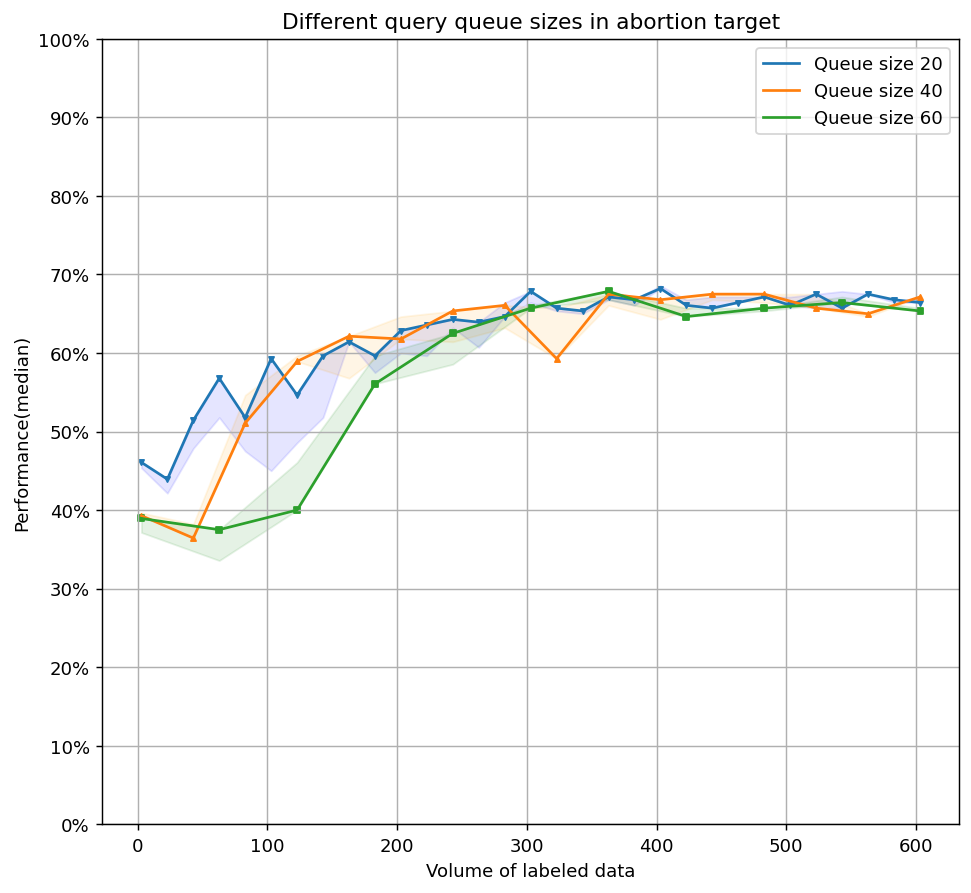

In [128]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(query_history[0],median_abortion1,label="Queue size 20")
ax.fill_between(query_history[0],min_abortion1,max_abortion1,color='blue', alpha=0.1)
ax.plot(query_history_abortion2[0],median_abortion2,label="Queue size 40")
ax.fill_between(query_history_abortion2[0],min_abortion2,max_abortion2,color='orange', alpha=0.1)
ax.plot(query_history_abortion3[0],median_abortion3,label="Queue size 60")
ax.fill_between(query_history_abortion3[0],min_abortion3,max_abortion3,color='green', alpha=0.1)
ax.scatter(query_history[0], median_abortion1, s=8,marker = "v")
ax.scatter(query_history_abortion2[0], median_abortion2, s=8,marker="^")
ax.scatter(query_history_abortion3[0], median_abortion3, s=8,marker = ",")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in abortion target')
ax.set_xlabel('Volume of labeled data')
ax.set_ylabel('Performance(median)')

plt.show()

# Atheism

In [7]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_atheism)} instances loaded")

val_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_atheism)} instances loaded")

test_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_atheism)} instances loaded")

num_classes = np.unique(train_dataset_atheism['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 461 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 52 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 220 instances loaded


In [8]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [9]:
active_mc_atheism1 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_atheism1 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_atheism['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    query = [3]
    num = 3
    performance_history_atheism=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        num = num +20
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_atheism)
    active_mc_atheism1.append(performance_history_atheism)
    query_history_atheism1.append(query)
    mcrun = mcrun + 1

[272 331 360]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:28.845687Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 18.65it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:34.389685Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 20.48it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:41.170272Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 24.54it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:45.868270Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.09it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:51.056799Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.00it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:28:56.851798Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 23.33it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:02.902797Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 23.27it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:08.743797Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.25it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:15.356799Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 18.24it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:22.347309Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 25.36it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:30.419309Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 26.19it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:37.402868Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.32it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:44.703869Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 22.91it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:29:53.186902Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 21.59it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:01.635426Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.42it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:09.611423Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.63it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:20.283996Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 22.81it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:28.499545Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.18it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:38.683883Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 28.26it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:48.294977Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.27it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:30:58.264505Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 25.81it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:08.242021Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:17.659073Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.2318181818181818, 0.2681818181818182, 0.33636363636363636, 0.41363636363636364, 0.5545454545454546, 0.5727272727272728, 0.6545454545454545, 0.6818181818181818, 0.7045454545454546, 0.7318181818181818, 0.7272727272727273, 0.7227272727272728, 0.7136363636363636, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:33.597782Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 30.27it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:41.105436Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 28.28it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:45.989420Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.97it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:52.216151Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.93it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:31:57.424152Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.46it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:03.008151Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 23.71it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:08.802664Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 29.49it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:14.554667Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.40it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:20.952663Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 29.16it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:27.082665Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 24.70it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:34.098664Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 23.95it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:40.508664Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.73it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:48.177702Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.50it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:32:55.645703Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 26.65it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:03.395703Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 25.27it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:11.335702Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.10it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:19.181702Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.39it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:27.681704Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 25.91it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:35.772703Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.37it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:44.801707Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.51it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:33:52.997704Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 24.92it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:02.577703Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:13.430225Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.06it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.19090909090909092, 0.20909090909090908, 0.21363636363636362, 0.3181818181818182, 0.4681818181818182, 0.5409090909090909, 0.6545454545454545, 0.7045454545454546, 0.7045454545454546, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:30.511335Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 21.82it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:35.341907Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 16.56it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:42.765425Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 18.07it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:48.519501Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.64it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:53.403015Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.13it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:34:59.222639Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 22.88it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:05.320495Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 28.53it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:11.467899Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.38it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:18.070556Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.04it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:25.014569Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 19.29it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:31.938240Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 27.49it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:38.807124Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.74it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:45.682571Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.50it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:35:53.364358Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 23.77it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:01.965012Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 22.93it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:10.034990Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.88it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:23.106688Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 16.58it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:32.093324Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 29.37it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:41.106657Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.05it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:49.987126Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.47it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:36:58.986237Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 24.52it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:09.625901Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:18.905021Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.89it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.19090909090909092, 0.20909090909090908, 0.21363636363636362, 0.3181818181818182, 0.4681818181818182, 0.5409090909090909, 0.6545454545454545, 0.7045454545454546, 0.7045454545454546, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:32.869014Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 21.26it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:37.744956Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 20.78it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:43.368883Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.66it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:49.643340Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.65it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:37:56.319388Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 20.00it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:02.741075Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 22.94it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:08.855565Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 27.82it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:15.035100Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.32it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:21.554553Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 29.76it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:28.018171Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 23.77it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:34.635275Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 28.52it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:41.656862Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.57it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:48.704040Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.19it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:38:56.297199Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 22.95it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:04.417540Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.88it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:11.729521Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.54it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:19.244724Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 25.19it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:28.004920Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 24.10it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:35.671760Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 25.03it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:44.753994Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.35it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:39:53.321307Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.09it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:02.304979Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.10it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:12.060125Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.75it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.19090909090909092, 0.20909090909090908, 0.21363636363636362, 0.3181818181818182, 0.4681818181818182, 0.5409090909090909, 0.6545454545454545, 0.7045454545454546, 0.7045454545454546, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[248  76 179]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:25.927140Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.71it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:30.133524Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 23.42it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:35.086667Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 24.61it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:40.179721Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.84it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:44.949071Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.25it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:51.293583Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 35.42it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:55.243386Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:40:59.993342Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.35it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:06.123190Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.43it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:12.565660Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 23.69it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:19.139237Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 30.44it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:25.727048Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.14it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:32.754369Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.00it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:40.008833Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 24.35it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:47.318920Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.32it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:41:55.246493Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.40it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:02.983849Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 28.94it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:11.401975Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 23.98it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:21.268422Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 25.77it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:30.383620Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.33it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:40.120624Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 28.29it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:49.109113Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.89it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:42:58.955040Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.26it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.19090909090909092, 0.20909090909090908, 0.21363636363636362, 0.3181818181818182, 0.4681818181818182, 0.5409090909090909, 0.6545454545454545, 0.7045454545454546, 0.7045454545454546, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7227272727272728, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [10]:
median_atheism1, min_atheism1,max_atheism1 = calculate(active_mc_atheism1)

In [11]:
active_mc_atheism2 = []
mcrun = 0
al_epochs=30
query_history_atheism2 = []
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_atheism['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 40, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        num = num+40
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_atheism)
    active_mc_atheism2.append(performance_history_atheism)
    query_history_atheism2.append(query)
    mcrun = mcrun + 1

[341 101 393]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:12.633521Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.45it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:17.068600Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.25it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:22.278201Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 22.68it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:28.621868Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 26.30it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:34.416276Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 22.82it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:41.933994Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 25.38it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:49.005967Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.42it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:43:57.236598Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.96it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:06.128425Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 28.93it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:14.093107Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.91it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:24.066993Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 24.60it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:33.771376Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.22272727272727272, 0.2681818181818182, 0.45454545454545453, 0.5727272727272728, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[202  40 104]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:47.003302Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 28.42it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:51.902190Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 19.70it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:44:58.697526Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 19.60it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:05.018185Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 28.07it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:11.820361Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.49it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:19.935675Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 23.83it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:26.805066Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 30.13it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:34.099941Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.82it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:41.861657Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.36it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:50.475190Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 31.85it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:45:59.402565Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 26.12it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:08.816301Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.45it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.18181818181818182, 0.24545454545454545, 0.2590909090909091, 0.37272727272727274, 0.5772727272727273, 0.6590909090909091, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[202  40 104]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:21.525365Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.17it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:26.558488Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 23.95it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:31.866232Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 29.97it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:37.534995Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 28.81it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:43.191764Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.04it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:50.184549Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 23.81it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:46:57.287393Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.90it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:04.991761Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.68it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:12.955940Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 29.81it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:21.511525Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.04it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:29.912110Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32.91it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:39.650299Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.46it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.18181818181818182, 0.24545454545454545, 0.2590909090909091, 0.37272727272727274, 0.5772727272727273, 0.6590909090909091, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[202  40 104]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:52.282095Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.91it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:47:57.992269Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 24.44it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:03.311781Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 27.04it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:08.510960Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 28.94it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:14.783361Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 23.12it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:21.698421Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 28.57it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:28.019299Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.92it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:35.905120Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.93it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:43.775191Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 28.53it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:48:51.636708Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 25.30it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:01.066096Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.46it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:10.122134Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.87it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.18181818181818182, 0.24545454545454545, 0.2590909090909091, 0.37272727272727274, 0.5772727272727273, 0.6590909090909091, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[202  40 104]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:23.782198Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.26it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:28.640213Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 23.93it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:33.979101Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 30.30it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:39.756594Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 24.28it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:46.479323Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.91it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:49:52.726082Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 28.73it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:00.216913Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 24.48it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:08.190783Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.97it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:15.751962Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 25.14it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:23.772243Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 25.22it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:33.120969Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 25.70it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:42.330433Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.18it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.18181818181818182, 0.24545454545454545, 0.2590909090909091, 0.37272727272727274, 0.5772727272727273, 0.6590909090909091, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [12]:
median_atheism2, min_atheism2,max_atheism2 = calculate(active_mc_atheism2)

In [13]:
active_mc_atheism3 = []
mcrun = 0
al_epochs=30
query_history_atheism3 = []
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_atheism['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 60, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        num = num + 60
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_atheism)
    active_mc_atheism3.append(performance_history_atheism)
    query_history_atheism3.append(query)
    mcrun = mcrun + 1

[425 380 239]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:50:55.288285Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.65it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:00.645467Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.52it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:06.342130Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 28.87it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:12.746908Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 29.35it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:19.453257Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.85it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:27.492132Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.47it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:35.889324Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 29.71it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:45.395803Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.03it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.18636363636363637, 0.2636363636363636, 0.4954545454545455, 0.6136363636363636, 0.7136363636363636, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[ 69  89 259]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:51:59.100818Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.48it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:04.645573Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.90it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:10.187572Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 23.93it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:16.716015Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 30.22it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:24.073146Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.81it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:31.901146Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.57it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:40.071574Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 24.49it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:52:49.141557Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.52it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.17272727272727273, 0.2590909090909091, 0.5409090909090909, 0.6318181818181818, 0.7090909090909091, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[ 69  89 259]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:02.249210Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.06it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:08.249563Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.62it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:13.504339Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 26.42it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:20.043550Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 27.10it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:26.666030Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 23.79it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:35.040793Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23.26it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:43.352595Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 27.71it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:53:52.510151Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.18it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.17272727272727273, 0.2590909090909091, 0.5409090909090909, 0.6318181818181818, 0.7090909090909091, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[ 69  89 259]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:06.254666Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.82it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:11.341095Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.19it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:17.406870Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 30.00it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:23.757335Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 24.28it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:30.774585Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.57it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:38.615090Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 24.26it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:47.020756Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 30.80it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:54:56.515713Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.16it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.17272727272727273, 0.2590909090909091, 0.5409090909090909, 0.6318181818181818, 0.7090909090909091, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]
[ 69  89 259]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:09.805350Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 28.99it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:14.415754Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.10it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:20.064962Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 23.72it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:26.802244Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 23.63it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:33.564438Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.23it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:41.575857Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.20it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:49.573651Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 31.74it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[15752-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-09T01:55:59.379933Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.34it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.17272727272727273, 0.2590909090909091, 0.5409090909090909, 0.6318181818181818, 0.7090909090909091, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [14]:
median_atheism3, min_atheism3,max_atheism3 = calculate(active_mc_atheism3)

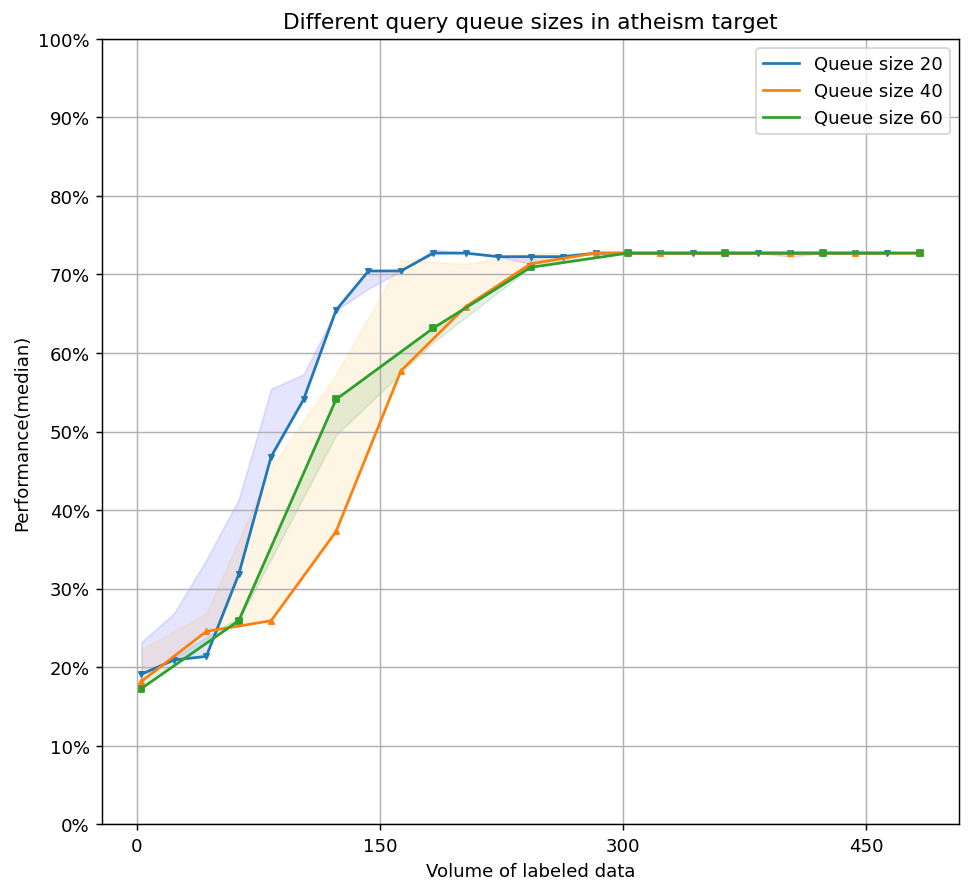

In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(query_history_atheism1[0],median_atheism1,label="Queue size 20")
ax.fill_between(query_history_atheism1[0],min_atheism1,max_atheism1,color='blue', alpha=0.1)
ax.plot(query_history_atheism2[0],median_atheism2,label="Queue size 40")
ax.fill_between(query_history_atheism2[0],min_atheism2,max_atheism2,color='orange', alpha=0.1)
ax.plot(query_history_atheism3[0],median_atheism3,label="Queue size 60")
ax.fill_between(query_history_atheism3[0],min_atheism3,max_atheism3,color='green', alpha=0.1)
ax.scatter(query_history_atheism1[0], median_atheism1, s=8,marker = "v")
ax.scatter(query_history_atheism2[0], median_atheism2, s=8,marker="^")
ax.scatter(query_history_atheism3[0],median_atheism3, s=8,marker = ",")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in atheism target')
ax.set_xlabel('Volume of labeled data')
ax.set_ylabel('Performance(median)')

plt.show()

# Climate

In [78]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_climate)} instances loaded")

val_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_climate)} instances loaded")

test_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_climate)} instances loaded")

num_classes = np.unique(train_dataset_climate['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 355 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 40 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 169 instances loaded


In [79]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [80]:
active_mc_climate1= []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_climate1 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_climate['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 10, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    num = 3
    query = [3]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        num = num + 10
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_climate)
    active_mc_climate1.append(performance_history_climate)
    query_history_climate1.append(query)
    mcrun = mcrun + 1

[95 44  9]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:27.585165Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 30.18it/s]
***** Running training *****
  Num examples = 13
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:30.478025Z [info     ] Start Predict                  dataset=342


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.15it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:33.308747Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:36.226044Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:39.157480Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:42.174592Z [info     ] Start Predict                  dataset=302


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.94it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:45.189965Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.57it/s]
***** Running training *****
  Num examples = 73
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:48.435744Z [info     ] Start Predict                  dataset=282


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.95it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:51.869011Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.85it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:55.385567Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.10it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:23:58.781408Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.24it/s]
***** Running training *****
  Num examples = 113
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:02.335392Z [info     ] Start Predict                  dataset=242


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.88it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:05.838792Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 133
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:09.598683Z [info     ] Start Predict                  dataset=222


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.82it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:13.379641Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.14it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:17.278658Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.84it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:21.226572Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:25.275929Z [info     ] Start Predict                  dataset=182


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:29.389753Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.65it/s]
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:33.587656Z [info     ] Start Predict                  dataset=162


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 35.05it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:37.872394Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:42.253089Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:46.716272Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 233
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:51.378401Z [info     ] Start Predict                  dataset=122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.71it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:24:56.077408Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:00.842487Z [info     ] Start Predict                  dataset=102


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.74it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:05.624509Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.92it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:10.609290Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.16it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:15.674791Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.32it/s]
***** Running training *****
  Num examples = 293
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:20.591422Z [info     ] Start Predict                  dataset=62


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.07it/s]


[0.3076923076923077, 0.3136094674556213, 0.3609467455621302, 0.40236686390532544, 0.47928994082840237, 0.46745562130177515, 0.48520710059171596, 0.5502958579881657, 0.6272189349112426, 0.6035502958579881, 0.6449704142011834, 0.6863905325443787, 0.6745562130177515, 0.727810650887574, 0.6863905325443787, 0.7159763313609467, 0.7159763313609467, 0.7100591715976331, 0.727810650887574, 0.727810650887574, 0.7100591715976331, 0.727810650887574, 0.7218934911242604, 0.7337278106508875, 0.7218934911242604, 0.7337278106508875, 0.727810650887574, 0.7041420118343196, 0.7159763313609467, 0.7218934911242604, 0.7337278106508875]
[105 117 236]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:23.140012Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.09it/s]
***** Running training *****
  Num examples = 13
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:25.815762Z [info     ] Start Predict                  dataset=342


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.90it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:28.554939Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.28it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:31.777556Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.51it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:35.499852Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.32it/s]
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:38.450567Z [info     ] Start Predict                  dataset=302


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.42it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:41.516118Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 73
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:44.681164Z [info     ] Start Predict                  dataset=282


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.15it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:47.931343Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.76it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:51.296653Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.33it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:54.579209Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 113
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:25:58.108578Z [info     ] Start Predict                  dataset=242


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.54it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:01.606467Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.75it/s]
***** Running training *****
  Num examples = 133
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:05.325816Z [info     ] Start Predict                  dataset=222


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:09.075412Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.97it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:12.837833Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.97it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:16.788057Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.74it/s]
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:20.844522Z [info     ] Start Predict                  dataset=182


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.69it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:25.000295Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.05it/s]
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:29.196066Z [info     ] Start Predict                  dataset=162


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:33.464553Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.25it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:37.766333Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.35it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:42.197084Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 233
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:46.843080Z [info     ] Start Predict                  dataset=122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.04it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:51.475231Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:26:56.297758Z [info     ] Start Predict                  dataset=102


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.31it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:01.123993Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.07it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:06.053670Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.11it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:11.103022Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.04it/s]
***** Running training *****
  Num examples = 293
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:16.151900Z [info     ] Start Predict                  dataset=62


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.87it/s]


[0.41420118343195267, 0.40828402366863903, 0.4437869822485207, 0.46745562130177515, 0.5739644970414202, 0.5680473372781065, 0.5621301775147929, 0.6094674556213018, 0.6272189349112426, 0.6449704142011834, 0.650887573964497, 0.6923076923076923, 0.6745562130177515, 0.7218934911242604, 0.6745562130177515, 0.7159763313609467, 0.727810650887574, 0.7159763313609467, 0.7100591715976331, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.7337278106508875]
[105 117 236]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:18.750870Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.10it/s]
***** Running training *****
  Num examples = 13
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:21.514706Z [info     ] Start Predict                  dataset=342


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:24.180939Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:27.078706Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.12it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:30.060170Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:33.094336Z [info     ] Start Predict                  dataset=302


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.32it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:36.579831Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.40it/s]
***** Running training *****
  Num examples = 73
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:40.158669Z [info     ] Start Predict                  dataset=282


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.82it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:43.643033Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.85it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:47.060474Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.42it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:50.424423Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 113
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:53.890224Z [info     ] Start Predict                  dataset=242


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 35.37it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:27:57.499546Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.05it/s]
***** Running training *****
  Num examples = 133
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:01.374250Z [info     ] Start Predict                  dataset=222


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.32it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:05.129263Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.80it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:08.979259Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:12.979182Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.23it/s]
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:17.010186Z [info     ] Start Predict                  dataset=182


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:21.258113Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.20it/s]
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:25.505751Z [info     ] Start Predict                  dataset=162


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 35.07it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:29.759360Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 35.08it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:34.186789Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.16it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:38.635927Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 30.13it/s]
***** Running training *****
  Num examples = 233
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:43.257884Z [info     ] Start Predict                  dataset=122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.57it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:47.886762Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:52.620044Z [info     ] Start Predict                  dataset=102


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.08it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:28:57.478329Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.07it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:02.410057Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.69it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:07.375349Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.86it/s]
***** Running training *****
  Num examples = 293
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:12.492390Z [info     ] Start Predict                  dataset=62


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.28it/s]


[0.41420118343195267, 0.40828402366863903, 0.4437869822485207, 0.46745562130177515, 0.5739644970414202, 0.5680473372781065, 0.5621301775147929, 0.6094674556213018, 0.6272189349112426, 0.6449704142011834, 0.650887573964497, 0.6923076923076923, 0.6745562130177515, 0.7218934911242604, 0.6745562130177515, 0.7159763313609467, 0.727810650887574, 0.7159763313609467, 0.7100591715976331, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.7337278106508875]
[105 117 236]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:14.993199Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 13
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:17.596036Z [info     ] Start Predict                  dataset=342


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.97it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:20.276093Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.70it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:23.109371Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 35.12it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:26.022930Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:29.006868Z [info     ] Start Predict                  dataset=302


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.00it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:32.020880Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.14it/s]
***** Running training *****
  Num examples = 73
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:35.186490Z [info     ] Start Predict                  dataset=282


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.68it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:38.468772Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.90it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:41.786350Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:45.284197Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.91it/s]
***** Running training *****
  Num examples = 113
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:48.863134Z [info     ] Start Predict                  dataset=242


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 34.99it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:52.576994Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.68it/s]
***** Running training *****
  Num examples = 133
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:56.130896Z [info     ] Start Predict                  dataset=222


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.85it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:29:59.941800Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:03.923885Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.45it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:07.906213Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:12.022179Z [info     ] Start Predict                  dataset=182


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.77it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:16.203705Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.50it/s]
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:20.535048Z [info     ] Start Predict                  dataset=162


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:24.864616Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.55it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:29.348566Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.89it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:33.829882Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 35.54it/s]
***** Running training *****
  Num examples = 233
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:38.383005Z [info     ] Start Predict                  dataset=122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.61it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:43.414922Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.30it/s]
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:48.062920Z [info     ] Start Predict                  dataset=102


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:52.843761Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.58it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:30:57.729053Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.54it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:02.837520Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 293
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:08.051551Z [info     ] Start Predict                  dataset=62


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.76it/s]


[0.41420118343195267, 0.40828402366863903, 0.4437869822485207, 0.46745562130177515, 0.5739644970414202, 0.5680473372781065, 0.5621301775147929, 0.6094674556213018, 0.6272189349112426, 0.6449704142011834, 0.650887573964497, 0.6923076923076923, 0.6745562130177515, 0.7218934911242604, 0.6745562130177515, 0.7159763313609467, 0.727810650887574, 0.7159763313609467, 0.7100591715976331, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.7337278106508875]
[105 117 236]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:10.555340Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.86it/s]
***** Running training *****
  Num examples = 13
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:13.154514Z [info     ] Start Predict                  dataset=342


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:15.885870Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.52it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:18.705270Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.01it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:21.683918Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 53
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:24.667991Z [info     ] Start Predict                  dataset=302


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:27.732112Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.66it/s]
***** Running training *****
  Num examples = 73
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:30.797499Z [info     ] Start Predict                  dataset=282


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.74it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:34.031360Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.14it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:37.924401Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 27.45it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:41.692548Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.78it/s]
***** Running training *****
  Num examples = 113
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:45.110343Z [info     ] Start Predict                  dataset=242


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.85it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:48.691448Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 133
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:52.357777Z [info     ] Start Predict                  dataset=222


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.72it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:56.055576Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 35.12it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:31:59.954507Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:03.878421Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.85it/s]
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:07.969978Z [info     ] Start Predict                  dataset=182


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.30it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:12.119398Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.74it/s]
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:16.348822Z [info     ] Start Predict                  dataset=162


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:20.681843Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.98it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:25.097081Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 30.21it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:31.801576Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.05it/s]
***** Running training *****
  Num examples = 233
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:38.197436Z [info     ] Start Predict                  dataset=122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.54it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:44.322181Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.19it/s]
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:50.305064Z [info     ] Start Predict                  dataset=102


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.86it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:55.036805Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.90it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:32:59.951860Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.94it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:04.893894Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 293
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:09.997455Z [info     ] Start Predict                  dataset=62


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.06it/s]


[0.41420118343195267, 0.40828402366863903, 0.4437869822485207, 0.46745562130177515, 0.5739644970414202, 0.5680473372781065, 0.5621301775147929, 0.6094674556213018, 0.6272189349112426, 0.6449704142011834, 0.650887573964497, 0.6923076923076923, 0.6745562130177515, 0.7218934911242604, 0.6745562130177515, 0.7159763313609467, 0.727810650887574, 0.7159763313609467, 0.7100591715976331, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.727810650887574, 0.7337278106508875]


In [81]:
median_climate1, min_climate1,max_climate1 = calculate(active_mc_climate1)

In [82]:
active_mc_climate2 = []
mcrun = 0
al_epochs=30
query_history_climate2 =[]
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_climate['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        num = num + 20
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_climate)
    active_mc_climate2.append(performance_history_climate)
    query_history_climate2.append(query)
    mcrun = mcrun + 1

[273   3 192]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:12.630408Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:15.380101Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.34it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:18.679327Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.24it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:22.143877Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:25.443008Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:28.792518Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.72it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:32.342432Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:36.179556Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 35.27it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:40.323016Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.90it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:44.938103Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.49it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:49.268955Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.02it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:53.766895Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.04it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:33:58.391664Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:03.179551Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.69it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:08.161081Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.16it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:13.310290Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.09it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:18.727562Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.02it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:24.390514Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.11it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.35502958579881655, 0.3668639053254438, 0.44970414201183434, 0.5857988165680473, 0.5976331360946746, 0.6627218934911243, 0.6923076923076923, 0.6863905325443787, 0.6982248520710059, 0.7218934911242604, 0.7159763313609467, 0.727810650887574, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7337278106508875, 0.7159763313609467, 0.727810650887574]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:32.755393Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:35.536047Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.12it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:38.468741Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:41.600299Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:44.907531Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 31.99it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:48.381777Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:51.998847Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:55.763997Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.45it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:34:59.811576Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.79it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:03.944498Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:08.308323Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.28it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:12.857458Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:17.552275Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:22.699444Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.40it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:27.800893Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:33.462537Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 28.34it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:39.214647Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.79it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:44.830996Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.26it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.40828402366863903, 0.40828402366863903, 0.4556213017751479, 0.5739644970414202, 0.6153846153846154, 0.6804733727810651, 0.6982248520710059, 0.6923076923076923, 0.7218934911242604, 0.7218934911242604, 0.7159763313609467, 0.7218934911242604, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:52.892594Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.43it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:55.625996Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.89it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:35:58.658705Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:01.825051Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.09it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:05.203863Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.99it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:08.821302Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:12.383813Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.76it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:16.110029Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:20.150187Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.03it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:24.466592Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.05it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:29.248711Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.64it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:33.730501Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.63it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:38.460380Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:43.341854Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.81it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:48.504145Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.95it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:53.675479Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.21it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:36:59.295661Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:04.751464Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.87it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.40828402366863903, 0.40828402366863903, 0.4556213017751479, 0.5739644970414202, 0.6153846153846154, 0.6804733727810651, 0.6982248520710059, 0.6923076923076923, 0.7218934911242604, 0.7218934911242604, 0.7159763313609467, 0.7218934911242604, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:13.354884Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.47it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:16.147763Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.39it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:19.083582Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.73it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:22.163426Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.29it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:25.578899Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:29.210886Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.40it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:33.244083Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.56it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:36.926403Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.55it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:40.972514Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.20it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:45.672567Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.53it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:50.386065Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:54.903159Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.42it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:37:59.601269Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:04.349263Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.82it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:09.280783Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:14.447026Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.18it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:20.077031Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.44it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:25.459783Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.55it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.40828402366863903, 0.40828402366863903, 0.4556213017751479, 0.5739644970414202, 0.6153846153846154, 0.6804733727810651, 0.6982248520710059, 0.6923076923076923, 0.7218934911242604, 0.7218934911242604, 0.7159763313609467, 0.7218934911242604, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[335 117 232]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:34.055395Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.57it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:36.822780Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.67it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:39.654789Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.54it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:43.234547Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 27.98it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:47.114113Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.63it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:50.484107Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.17it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:54.000163Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:38:57.816017Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.00it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:01.928837Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.85it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:06.090407Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.54it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:10.488379Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.44it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:14.974142Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 35.52it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:20.151927Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.04it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:25.116632Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.90it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:30.086819Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 30.95it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:35.263411Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.82it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:40.610499Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.47it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:46.226348Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.40828402366863903, 0.40828402366863903, 0.4556213017751479, 0.5739644970414202, 0.6153846153846154, 0.6804733727810651, 0.6982248520710059, 0.6923076923076923, 0.7218934911242604, 0.7218934911242604, 0.7159763313609467, 0.7218934911242604, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]


In [83]:
median_climate2, min_climate2,max_climate2 = calculate(active_mc_climate2)

In [84]:
active_mc_climate3 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_climate3 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_climate['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 30, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    num = 3
    query = [3]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        num = num + 30
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_climate)
    active_mc_climate3.append(performance_history_climate)
    query_history_climate3.append(query)
    mcrun = mcrun + 1

[132  33 225]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:54.211848Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.77it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:39:57.111211Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.15it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:00.711484Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 27.58it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:04.818914Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:08.502240Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.77it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:12.525189Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.65it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:16.749422Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:21.235789Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.11it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:28.793513Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.47it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:34.126737Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.74it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:39.491716Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.49it/s]
***** Running training *****
  Num examples = 333
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:44.879831Z [info     ] Start Predict                  dataset=22


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.64it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.40828402366863903, 0.40236686390532544, 0.46745562130177515, 0.591715976331361, 0.650887573964497, 0.6982248520710059, 0.727810650887574, 0.7159763313609467, 0.7159763313609467, 0.727810650887574, 0.7218934911242604, 0.727810650887574, 0.7396449704142012]
[ 49 254 148]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:40:56.960966Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.41it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:00.318999Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.75it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:04.902787Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 27.41it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:09.320614Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.52it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:13.281687Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:17.344390Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.73it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:21.559634Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.43it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:25.917025Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.21it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:30.793515Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.66it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:35.890674Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.65it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:41.127480Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.24it/s]
***** Running training *****
  Num examples = 333
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:46.702836Z [info     ] Start Predict                  dataset=22


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.50it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.3136094674556213, 0.3136094674556213, 0.4260355029585799, 0.5443786982248521, 0.621301775147929, 0.6982248520710059, 0.7159763313609467, 0.7159763313609467, 0.7159763313609467, 0.7218934911242604, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[ 49 254 148]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:54.672275Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:41:57.636222Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.05it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:00.737490Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.98it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:04.135530Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.40it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:07.886770Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:11.926018Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.03it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:16.178213Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.07it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:20.740707Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 32.86it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:25.872522Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.59it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:31.078087Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.96it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:36.502096Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 39.15it/s]
***** Running training *****
  Num examples = 333
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:41.925858Z [info     ] Start Predict                  dataset=22


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.01it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.3136094674556213, 0.3136094674556213, 0.4260355029585799, 0.5443786982248521, 0.621301775147929, 0.6982248520710059, 0.7159763313609467, 0.7159763313609467, 0.7159763313609467, 0.7218934911242604, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[ 49 254 148]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:49.986628Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.78it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:53.016410Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.40it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:42:56.781826Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 26.81it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:00.764875Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:04.661830Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:08.857931Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.80it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:13.572959Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.14it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:18.004753Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.17it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:22.821658Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:27.920659Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.87it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:33.233470Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.88it/s]
***** Running training *****
  Num examples = 333
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:38.831609Z [info     ] Start Predict                  dataset=22


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.3136094674556213, 0.3136094674556213, 0.4260355029585799, 0.5443786982248521, 0.621301775147929, 0.6982248520710059, 0.7159763313609467, 0.7159763313609467, 0.7159763313609467, 0.7218934911242604, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]
[ 49 254 148]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:46.805042Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:49.733736Z [info     ] Start Predict                  dataset=322


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.07it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:53.431623Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 27.19it/s]
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:43:57.197374Z [info     ] Start Predict                  dataset=262


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:01.156652Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 153
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:05.206179Z [info     ] Start Predict                  dataset=202


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.62it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:09.640342Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.57it/s]
***** Running training *****
  Num examples = 213
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:14.137331Z [info     ] Start Predict                  dataset=142


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.86it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:18.933312Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.19it/s]
***** Running training *****
  Num examples = 273
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:23.981523Z [info     ] Start Predict                  dataset=82


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:29.249594Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.24it/s]
***** Running training *****
  Num examples = 333
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:34.729815Z [info     ] Start Predict                  dataset=22


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.96it/s]
***** Running training *****
  Num examples = 355
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[0.3136094674556213, 0.3136094674556213, 0.4260355029585799, 0.5443786982248521, 0.621301775147929, 0.6982248520710059, 0.7159763313609467, 0.7159763313609467, 0.7159763313609467, 0.7218934911242604, 0.7218934911242604, 0.7218934911242604, 0.7337278106508875]


In [85]:
median_climate3, min_climate3,max_climate3 = calculate(active_mc_climate3)

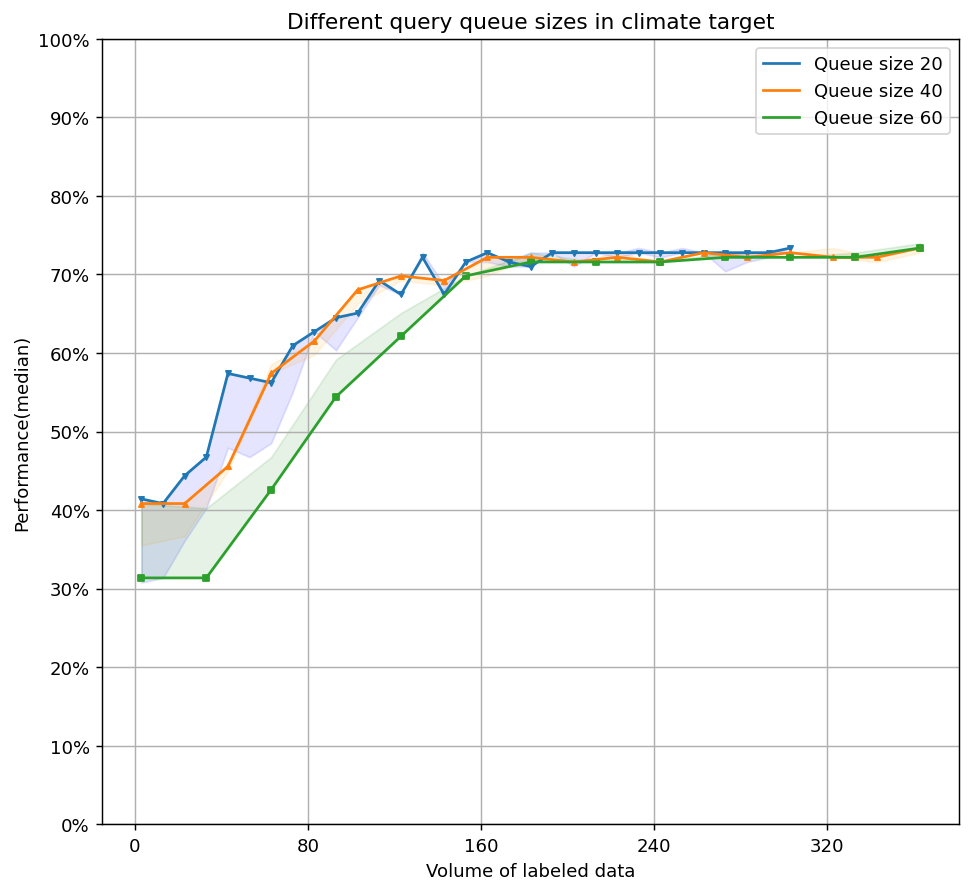

In [86]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(query_history_climate1[0],median_climate1,label="Queue size 20")
ax.fill_between(query_history_climate1[0],min_climate1,max_climate1,color='blue', alpha=0.1)
ax.plot(query_history_climate2[0],median_climate2,label="Queue size 40")
ax.fill_between(query_history_climate2[0],min_climate2,max_climate2,color='orange', alpha=0.1)
ax.plot(query_history_climate3[0],median_climate3,label="Queue size 60")
ax.fill_between(query_history_climate3[0],min_climate3,max_climate3,color='green', alpha=0.1)
ax.scatter(query_history_climate1[0], median_climate1, s=8,marker = "v")
ax.scatter(query_history_climate2[0], median_climate2, s=8,marker="^")
ax.scatter(query_history_climate3[0], median_climate3, s=8,marker = ",")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in climate target')
ax.set_xlabel('Volume of labeled data')
ax.set_ylabel('Performance(median)')

plt.show()

# Feminist

In [96]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_feminist)} instances loaded")

val_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_feminist)} instances loaded")

test_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_feminist)} instances loaded")

num_classes = np.unique(train_dataset_feminist['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 597 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 67 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 285 instances loaded


In [97]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [98]:
active_mc_feminist1 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_feminist1 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_feminist['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        num = num + 20
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_feminist)
    active_mc_feminist1.append(performance_history_feminist)
    query_history_feminist1.append(query)
    mcrun = mcrun + 1

[372 399 464]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:01.751788Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 30.47it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:06.228742Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.48it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:10.895988Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.96it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:15.536834Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:20.451581Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:25.482175Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:30.598633Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.46it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:35.913278Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:41.476833Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.75it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:47.159449Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:53.139538Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.09it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:35:59.097823Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.06it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:05.335353Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:11.700837Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:18.314407Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.72it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:25.161966Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:32.193030Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.79it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:39.322900Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.50it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:46.572518Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.05it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:36:54.088156Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.41it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:01.967271Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.01it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:09.631554Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.62it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:17.347130Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.46it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:25.408406Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.88it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:33.772389Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.50it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:42.041344Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.44it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:50.684215Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.82it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:37:59.365533Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.84it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:08.227315Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.93it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:17.331369Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.20it/s]


[0.5263157894736842, 0.4982456140350877, 0.5017543859649123, 0.5263157894736842, 0.5403508771929825, 0.5929824561403508, 0.5929824561403508, 0.5754385964912281, 0.6105263157894737, 0.5929824561403508, 0.5929824561403508, 0.624561403508772, 0.5964912280701754, 0.624561403508772, 0.631578947368421, 0.6210526315789474, 0.6210526315789474, 0.631578947368421, 0.6, 0.624561403508772, 0.6385964912280702, 0.6421052631578947, 0.6140350877192983, 0.6350877192982456, 0.6421052631578947, 0.6526315789473685, 0.6385964912280702, 0.624561403508772, 0.624561403508772, 0.6210526315789474, 0.6385964912280702]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:21.238659Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.97it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:25.554778Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.66it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:29.954942Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.28it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:34.551873Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.18it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:39.383533Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:46.332252Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 34.07it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:52.278129Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.47it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:38:57.744591Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:03.265997Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.23it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:09.011184Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.57it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:15.055939Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.24it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:21.133976Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.59it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:27.470082Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:33.786984Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:40.413465Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:47.310709Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.37it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:39:54.343618Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.23it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:01.588214Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.78it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:08.954230Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:16.589175Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.88it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:24.290094Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.36it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:32.134654Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.55it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:39.959480Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.07it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:48.175322Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.08it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:40:56.487133Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.61it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:05.065681Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.95it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:13.699282Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.21it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:22.478471Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.26it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:31.702705Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.25it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:41.139310Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.66it/s]


[0.512280701754386, 0.49122807017543857, 0.49122807017543857, 0.519298245614035, 0.5649122807017544, 0.5754385964912281, 0.5614035087719298, 0.4982456140350877, 0.49122807017543857, 0.6175438596491228, 0.5964912280701754, 0.5333333333333333, 0.6175438596491228, 0.5894736842105263, 0.6070175438596491, 0.6280701754385964, 0.6280701754385964, 0.631578947368421, 0.631578947368421, 0.6280701754385964, 0.6421052631578947, 0.6421052631578947, 0.6385964912280702, 0.631578947368421, 0.6035087719298246, 0.6421052631578947, 0.631578947368421, 0.6421052631578947, 0.6105263157894737, 0.6350877192982456, 0.624561403508772]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:44.988638Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 33.33it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:49.321348Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.82it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:53.757224Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.81it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:41:58.791251Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 28.75it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:04.003018Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.15it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:08.984807Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 33.48it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:14.149672Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:19.609175Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:26.190261Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:31.988790Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.75it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:38.977801Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.67it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:46.055755Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.00it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:52.516581Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:42:58.979323Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.09it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:05.616463Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.81it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:12.507986Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 29.96it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:20.966026Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 26.61it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:28.303081Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.13it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:35.527354Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.95it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:42.806679Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.28it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:50.298751Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:43:57.812689Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.36it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:07.927257Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.49it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:15.947864Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:24.245624Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:32.601998Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.16it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:41.309915Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.18it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:50.745257Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.33it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:44:59.815448Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.67it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:09.037365Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.72it/s]


[0.512280701754386, 0.49122807017543857, 0.49122807017543857, 0.519298245614035, 0.5649122807017544, 0.5754385964912281, 0.5614035087719298, 0.4982456140350877, 0.49122807017543857, 0.6175438596491228, 0.5964912280701754, 0.5333333333333333, 0.6175438596491228, 0.5894736842105263, 0.6070175438596491, 0.6280701754385964, 0.6280701754385964, 0.631578947368421, 0.631578947368421, 0.6280701754385964, 0.6421052631578947, 0.6421052631578947, 0.6385964912280702, 0.631578947368421, 0.6035087719298246, 0.6421052631578947, 0.631578947368421, 0.6421052631578947, 0.6105263157894737, 0.6350877192982456, 0.624561403508772]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:12.493522Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.21it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:17.101526Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 27.43it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:22.192745Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.71it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:26.809685Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 33.67it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:31.620219Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.70it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:37.317992Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 26.58it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:43.119526Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.95it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:48.497464Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:45:54.052934Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.58it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:00.125820Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.40it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:06.627717Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:12.822376Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:19.626294Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 31.94it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:26.088154Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:32.839365Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.80it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:40.227432Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.42it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:48.123773Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 27.38it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:46:55.495822Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:02.826686Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.89it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:10.963204Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 26.86it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:18.955332Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.37it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:26.602993Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.79it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:35.141147Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.25it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:43.599748Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.82it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:47:52.322429Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 27.28it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:01.208073Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:10.461535Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.06it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:19.179729Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 28.48it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:28.697921Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:37.862725Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.54it/s]


[0.512280701754386, 0.49122807017543857, 0.49122807017543857, 0.519298245614035, 0.5649122807017544, 0.5754385964912281, 0.5614035087719298, 0.4982456140350877, 0.49122807017543857, 0.6175438596491228, 0.5964912280701754, 0.5333333333333333, 0.6175438596491228, 0.5894736842105263, 0.6070175438596491, 0.6280701754385964, 0.6280701754385964, 0.631578947368421, 0.631578947368421, 0.6280701754385964, 0.6421052631578947, 0.6421052631578947, 0.6385964912280702, 0.631578947368421, 0.6035087719298246, 0.6421052631578947, 0.631578947368421, 0.6421052631578947, 0.6105263157894737, 0.6350877192982456, 0.624561403508772]
[252 477 368]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:42.738990Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 30.11it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:49.774407Z [info     ] Start Predict                  dataset=574


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 27.93it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:48:55.095455Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 28.84it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:00.045862Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 34.00it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:04.818832Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:10.311900Z [info     ] Start Predict                  dataset=494


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 26.71it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:16.219222Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:22.286570Z [info     ] Start Predict                  dataset=454


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:27.725191Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.09it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:33.469042Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.87it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:40.378385Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.97it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:46.870299Z [info     ] Start Predict                  dataset=374


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.89it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:49:53.130699Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 31.38it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:00.531451Z [info     ] Start Predict                  dataset=334


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.39it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:07.310956Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.45it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:14.006569Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.83it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:21.293943Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 27.07it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:29.606800Z [info     ] Start Predict                  dataset=254


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.58it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:37.343638Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.10it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:45.195277Z [info     ] Start Predict                  dataset=214


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 27.53it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:50:53.459868Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.71it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:01.571511Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:11.007517Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.05it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:19.499743Z [info     ] Start Predict                  dataset=134


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:28.406544Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.71it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:36.634258Z [info     ] Start Predict                  dataset=94


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.67it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:46.521659Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.17it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:51:55.510043Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.20it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:05.942564Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.88it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:15.028184Z [info     ] Start Predict                  dataset=14


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.24it/s]


[0.512280701754386, 0.49122807017543857, 0.49122807017543857, 0.519298245614035, 0.5649122807017544, 0.5754385964912281, 0.5614035087719298, 0.4982456140350877, 0.49122807017543857, 0.6175438596491228, 0.5964912280701754, 0.5333333333333333, 0.6175438596491228, 0.5894736842105263, 0.6070175438596491, 0.6280701754385964, 0.6280701754385964, 0.631578947368421, 0.631578947368421, 0.6280701754385964, 0.6421052631578947, 0.6421052631578947, 0.6385964912280702, 0.631578947368421, 0.6035087719298246, 0.6421052631578947, 0.631578947368421, 0.6421052631578947, 0.6105263157894737, 0.6350877192982456, 0.624561403508772]


In [99]:
median_feminist1, min_feminist1,max_feminist1= calculate(active_mc_feminist1)

In [100]:
active_mc_feminist2 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_feminist2=[]
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_feminist['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 40, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        num = num +40
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_feminist)
    active_mc_feminist2.append(performance_history_feminist)
    query_history_feminist2.append(query)
    mcrun = mcrun + 1

[129 169  48]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:19.274864Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.97it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:24.828537Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.87it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:30.292308Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 26.52it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:36.261064Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.86it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:41.816019Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:48.592087Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.23it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:52:55.889082Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.62it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:02.493803Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.15it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:09.907081Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 28.07it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:18.497440Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.42it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:26.390287Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 28.41it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:35.134050Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.00it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:43.534185Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.41it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:53:53.808994Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.97it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:03.057038Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.67it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.512280701754386, 0.48771929824561405, 0.543859649122807, 0.519298245614035, 0.5859649122807018, 0.5649122807017544, 0.5929824561403508, 0.5859649122807018, 0.6210526315789474, 0.631578947368421, 0.624561403508772, 0.6140350877192983, 0.6210526315789474, 0.6385964912280702, 0.631578947368421, 0.631578947368421]
[272 441 502]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:16.684075Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 31.86it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:21.641822Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.51it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:27.554221Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:32.766746Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.36it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:39.220463Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:45.191721Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.04it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:52.445940Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.67it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:54:59.170066Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.38it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:07.226419Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 28.34it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:14.913867Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.68it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:22.604613Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.65it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:32.342571Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.05it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:41.086165Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:55:50.449410Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.27it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:00.062338Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.81it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.519298245614035, 0.512280701754386, 0.5824561403508772, 0.512280701754386, 0.5789473684210527, 0.5333333333333333, 0.5964912280701754, 0.5684210526315789, 0.6070175438596491, 0.6070175438596491, 0.5719298245614035, 0.6350877192982456, 0.6280701754385964, 0.624561403508772, 0.6491228070175439, 0.6350877192982456]
[272 441 502]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:14.155303Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.17it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:19.911870Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 34.34it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:25.110160Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 27.75it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:31.161164Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:37.284919Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 27.78it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:43.905239Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.56it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:50.956356Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.10it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:56:57.464177Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.57it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:05.595080Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 27.24it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:13.421991Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.86it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:22.805082Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 26.41it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:31.439467Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.66it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:41.041680Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.49it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:57:50.229123Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 36.71it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:00.470738Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.06it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.519298245614035, 0.512280701754386, 0.5824561403508772, 0.512280701754386, 0.5789473684210527, 0.5333333333333333, 0.5964912280701754, 0.5684210526315789, 0.6070175438596491, 0.6070175438596491, 0.5719298245614035, 0.6350877192982456, 0.6280701754385964, 0.624561403508772, 0.6491228070175439, 0.6350877192982456]
[272 441 502]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:14.046604Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.41it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:19.515499Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.39it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:25.231124Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 27.93it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:31.064500Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.94it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:37.564067Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.25it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:43.587609Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.40it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:51.738805Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 31.52it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:58:58.510001Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.48it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:07.053814Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 28.39it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:15.106875Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.32it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:22.879869Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.73it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:31.921790Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.73it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:41.397587Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.95it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:59:50.447593Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.27it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:01.181160Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.11it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.519298245614035, 0.512280701754386, 0.5824561403508772, 0.512280701754386, 0.5789473684210527, 0.5333333333333333, 0.5964912280701754, 0.5684210526315789, 0.6070175438596491, 0.6070175438596491, 0.5719298245614035, 0.6350877192982456, 0.6280701754385964, 0.624561403508772, 0.6491228070175439, 0.6350877192982456]
[272 441 502]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:14.174496Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.53it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:19.241640Z [info     ] Start Predict                  dataset=554


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 27.81it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:25.147991Z [info     ] Start Predict                  dataset=514


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 27.19it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:31.360674Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:36.981066Z [info     ] Start Predict                  dataset=434


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 30.90it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:43.918530Z [info     ] Start Predict                  dataset=394


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.43it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:51.186502Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.61it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:00:58.819450Z [info     ] Start Predict                  dataset=314


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.20it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:06.386250Z [info     ] Start Predict                  dataset=274


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.99it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:14.099792Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.17it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:23.156816Z [info     ] Start Predict                  dataset=194


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.64it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:31.870353Z [info     ] Start Predict                  dataset=154


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 26.40it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:40.851991Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:01:50.269866Z [info     ] Start Predict                  dataset=74


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.10it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:00.189854Z [info     ] Start Predict                  dataset=34


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.49it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.519298245614035, 0.512280701754386, 0.5824561403508772, 0.512280701754386, 0.5789473684210527, 0.5333333333333333, 0.5964912280701754, 0.5684210526315789, 0.6070175438596491, 0.6070175438596491, 0.5719298245614035, 0.6350877192982456, 0.6280701754385964, 0.624561403508772, 0.6491228070175439, 0.6350877192982456]


In [101]:
median_feminist2, min_feminist2,max_feminist2= calculate(active_mc_feminist2)

In [102]:
active_mc_feminist3 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_feminist3 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_feminist['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 60, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        num = num + 60
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_feminist)
    active_mc_feminist3.append(performance_history_feminist)
    query_history_feminist3.append(query)
    mcrun = mcrun + 1

[ 49  29 542]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:14.560955Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.43it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:19.965816Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.24it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:26.493458Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.77it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:33.429842Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.98it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:39.821067Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 30.57it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:47.981343Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 26.79it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:02:56.081817Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:05.364309Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.32it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:14.548034Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.02it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:23.525693Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.17it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.45263157894736844, 0.43859649122807015, 0.5508771929824562, 0.6035087719298246, 0.6105263157894737, 0.6350877192982456, 0.6210526315789474, 0.6070175438596491, 0.6350877192982456, 0.631578947368421, 0.6385964912280702]
[174 288 480]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:38.576837Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.76it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:44.097400Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.14it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:49.443919Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.22it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:03:56.196701Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.60it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:02.580292Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:10.606972Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 27.60it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:18.797885Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.63it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:27.339237Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.47it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:37.546686Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 25.65it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:04:48.769447Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.98it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.4245614035087719, 0.40350877192982454, 0.4982456140350877, 0.5368421052631579, 0.5228070175438596, 0.5859649122807018, 0.5824561403508772, 0.5929824561403508, 0.6, 0.631578947368421, 0.6385964912280702]
[174 288 480]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:02.161101Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 28.51it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:07.767193Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.58it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:13.778317Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.02it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:20.739271Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.87it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:28.429390Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:36.099838Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.11it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:44.234977Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.02it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:05:52.701787Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.05it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:02.473217Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.57it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:11.372172Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.23it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.4245614035087719, 0.40350877192982454, 0.4982456140350877, 0.5368421052631579, 0.5228070175438596, 0.5859649122807018, 0.5824561403508772, 0.5929824561403508, 0.6, 0.631578947368421, 0.6385964912280702]
[174 288 480]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:26.113611Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 33.40it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:31.333311Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.29it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:37.195033Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:43.712380Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.57it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:50.624995Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 31.22it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:06:58.449273Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.70it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:06.239230Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.21it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:14.713793Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.75it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:24.585827Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 27.15it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:33.771386Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.96it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.4245614035087719, 0.40350877192982454, 0.4982456140350877, 0.5368421052631579, 0.5228070175438596, 0.5859649122807018, 0.5824561403508772, 0.5929824561403508, 0.6, 0.631578947368421, 0.6385964912280702]
[174 288 480]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:48.264955Z [info     ] Start Predict                  dataset=594


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 27.38it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:54.016843Z [info     ] Start Predict                  dataset=534


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 27.26it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:07:59.918165Z [info     ] Start Predict                  dataset=474


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.77it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:06.166000Z [info     ] Start Predict                  dataset=414


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.23it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:13.754701Z [info     ] Start Predict                  dataset=354


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 27.65it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:21.309268Z [info     ] Start Predict                  dataset=294


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:29.036708Z [info     ] Start Predict                  dataset=234


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.39it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:37.721638Z [info     ] Start Predict                  dataset=174


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:48.660976Z [info     ] Start Predict                  dataset=114


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 32.40it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T13:08:57.757679Z [info     ] Start Predict                  dataset=54


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 28.99it/s]
***** Running training *****
  Num examples = 597
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[0.4245614035087719, 0.40350877192982454, 0.4982456140350877, 0.5368421052631579, 0.5228070175438596, 0.5859649122807018, 0.5824561403508772, 0.5929824561403508, 0.6, 0.631578947368421, 0.6385964912280702]


In [103]:
median_feminist3, min_feminist3,max_feminist3= calculate(active_mc_feminist3)

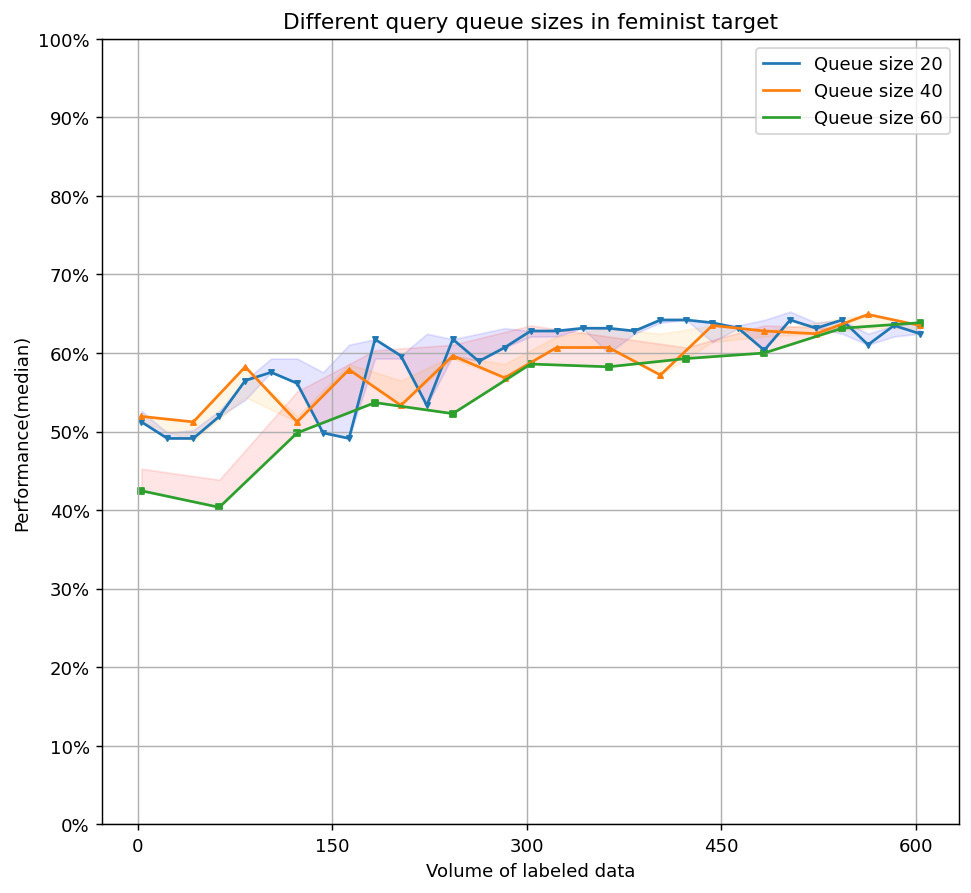

In [104]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(query_history_feminist1[0],median_feminist1,label="Queue size 20")
ax.fill_between(query_history_feminist1[0],min_feminist1,max_feminist1,color='blue', alpha=0.1)
ax.plot(query_history_feminist2[0],median_feminist2,label="Queue size 40")
ax.fill_between(query_history_feminist2[0],min_feminist2,max_feminist2,color='orange', alpha=0.1)
ax.plot(query_history_feminist3[0],median_feminist3,label="Queue size 60")
ax.fill_between(query_history_feminist3[0],min_feminist3,max_feminist3,color='red', alpha=0.1)
ax.scatter(query_history_feminist1[0], median_feminist1, s=8,marker = "v")
ax.scatter(query_history_feminist2[0], median_feminist2, s=8,marker="^")
ax.scatter(query_history_feminist3[0], median_feminist3, s=8,marker = ",")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in feminist target')
ax.set_xlabel('Volume of labeled data')
ax.set_ylabel('Performance(median)')

plt.show()

# Hillary

In [87]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_hillary)} instances loaded")

val_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_hillary)} instances loaded")

test_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_hillary)} instances loaded")

num_classes = np.unique(train_dataset_hillary['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 620 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 69 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 295 instances loaded


In [88]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [89]:
active_mc_hillary1 = []
mcrun = 0
al_epochs=30
query_history_hillary1 = []
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_hillary['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        num = num + 20
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_hillary)
    active_mc_hillary1.append(performance_history_hillary)
    query_history_hillary1.append(query)
    mcrun = mcrun + 1

[317 291 549]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:49.291264Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 26.98it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:54.471240Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 33.48it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:44:59.010464Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.56it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:03.708931Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.18it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:09.167854Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.56it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:14.706437Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 34.10it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:20.012670Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.08it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:25.328580Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.71it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:31.042744Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.70it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:36.825516Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.07it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:44.543087Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.58it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:50.777841Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.90it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:45:57.216746Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.90it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:03.748952Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.11it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:10.912193Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:17.836282Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.23it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:24.873924Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.36it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:32.123860Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.92it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:39.610349Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.47it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:47.733155Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:46:55.499544Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.50it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:03.860976Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.03it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:13.336890Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.93it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:22.982427Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.62it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:31.360946Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.88it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:39.948764Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.18it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:48.670617Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.61it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:47:57.564748Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:06.742628Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.49it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:16.903928Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.80it/s]


[0.43389830508474575, 0.4067796610169492, 0.5084745762711864, 0.5084745762711864, 0.5457627118644067, 0.559322033898305, 0.5661016949152542, 0.5796610169491525, 0.5864406779661017, 0.5864406779661017, 0.5728813559322034, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271, 0.576271186440678, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5728813559322034, 0.5830508474576271, 0.5864406779661017, 0.576271186440678, 0.5830508474576271, 0.5796610169491525, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:20.736027Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.19it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:25.169119Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 32.08it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:30.285937Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 27.22it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:35.696622Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.64it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:41.812287Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.38it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:47.710412Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 31.42it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:53.224172Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.85it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:48:59.248138Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.80it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:05.019052Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.19it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:10.819566Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.89it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:17.351523Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.24it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:24.235507Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.28it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:30.580113Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.86it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:37.420694Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.67it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:44.093680Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.41it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:51.668781Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.43it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:49:58.755426Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.44it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:06.600864Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 31.09it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:14.151220Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.84it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:22.846265Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:30.606811Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:38.423467Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:47.203175Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.73it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:50:57.126817Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:05.727330Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.18it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:14.976244Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:23.889988Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.86it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:32.904109Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.98it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:42.170617Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.52it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:51.516375Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.10it/s]


[0.39661016949152544, 0.38305084745762713, 0.423728813559322, 0.43728813559322033, 0.48135593220338985, 0.5389830508474577, 0.5016949152542373, 0.5423728813559322, 0.5322033898305085, 0.5796610169491525, 0.5288135593220339, 0.5728813559322034, 0.5830508474576271, 0.576271186440678, 0.5694915254237288, 0.5661016949152542, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5694915254237288, 0.5830508474576271, 0.5864406779661017, 0.5796610169491525, 0.5830508474576271, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:55.065332Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.88it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:51:59.896645Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.84it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:05.227111Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.88it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:10.709919Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 34.01it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:16.334680Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.73it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:23.530296Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.56it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:30.411540Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.13it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:36.970735Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.94it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:42.758312Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 31.21it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:50.779805Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.60it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:52:56.808611Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.32it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:03.040775Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.58it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:09.423201Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.44it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:16.053664Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.11it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:23.435159Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.19it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:30.233077Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.68it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:37.347383Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:44.693424Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:52.190929Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.44it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:53:59.889836Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.52it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:07.993899Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.88it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:15.798608Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.69it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:23.814056Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.66it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:32.044932Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.44it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:41.556648Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.34it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:50.287490Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.54it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:54:59.619002Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 32.48it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:08.647173Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.54it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:18.162960Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.58it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:27.509666Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.37it/s]


[0.39661016949152544, 0.38305084745762713, 0.423728813559322, 0.43728813559322033, 0.48135593220338985, 0.5389830508474577, 0.5016949152542373, 0.5423728813559322, 0.5322033898305085, 0.5796610169491525, 0.5288135593220339, 0.5728813559322034, 0.5830508474576271, 0.576271186440678, 0.5694915254237288, 0.5661016949152542, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5694915254237288, 0.5830508474576271, 0.5864406779661017, 0.5796610169491525, 0.5830508474576271, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:31.189816Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.22it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:35.977225Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 26.79it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:41.153110Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.78it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:46.353641Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 29.45it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:51.639618Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.70it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:55:56.750186Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:02.078330Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:07.708846Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:14.108743Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.62it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:20.056752Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.80it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:25.977373Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:32.269076Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:39.285460Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.28it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:45.820006Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.65it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:52.697722Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:56:59.676568Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.43it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:07.771984Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.37it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:16.322248Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.85it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:23.951806Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.33it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:31.349337Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.25it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:39.829745Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.19it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:49.094919Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:57:57.274365Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.92it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:05.571080Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.40it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:15.702589Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:24.281439Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.74it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:33.197325Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.23it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:42.768701Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.55it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:58:53.368008Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.91it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:02.836056Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.59it/s]


[0.39661016949152544, 0.38305084745762713, 0.423728813559322, 0.43728813559322033, 0.48135593220338985, 0.5389830508474577, 0.5016949152542373, 0.5423728813559322, 0.5322033898305085, 0.5796610169491525, 0.5288135593220339, 0.5728813559322034, 0.5830508474576271, 0.576271186440678, 0.5694915254237288, 0.5661016949152542, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5694915254237288, 0.5830508474576271, 0.5864406779661017, 0.5796610169491525, 0.5830508474576271, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[503 141 583]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:06.916912Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 27.10it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:12.067833Z [info     ] Start Predict                  dataset=597


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:02<00:00, 33.71it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:16.665600Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.65it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:21.428808Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.94it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:26.978508Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.61it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:32.227760Z [info     ] Start Predict                  dataset=517


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:37.624358Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:43.125843Z [info     ] Start Predict                  dataset=477


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:48.819583Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.86it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T11:59:55.022945Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.68it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:00.939717Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.10it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:07.238645Z [info     ] Start Predict                  dataset=397


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.75it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:14.576977Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.28it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:21.544462Z [info     ] Start Predict                  dataset=357


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.96it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:28.572822Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:35.472360Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.73it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:42.527807Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:50.655900Z [info     ] Start Predict                  dataset=277


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.27it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:00:58.346071Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:05.975379Z [info     ] Start Predict                  dataset=237


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.10it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:13.610520Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.80it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:21.557458Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.79it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:29.702186Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.60it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:38.050461Z [info     ] Start Predict                  dataset=157


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.06it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:47.302517Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.23it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:01:56.344764Z [info     ] Start Predict                  dataset=117


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.41it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:05.125452Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.66it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:13.990096Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:23.172710Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.81it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:33.320545Z [info     ] Start Predict                  dataset=37


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.15it/s]


[0.39661016949152544, 0.38305084745762713, 0.423728813559322, 0.43728813559322033, 0.48135593220338985, 0.5389830508474577, 0.5016949152542373, 0.5423728813559322, 0.5322033898305085, 0.5796610169491525, 0.5288135593220339, 0.5728813559322034, 0.5830508474576271, 0.576271186440678, 0.5694915254237288, 0.5661016949152542, 0.5796610169491525, 0.5830508474576271, 0.5796610169491525, 0.5694915254237288, 0.5830508474576271, 0.5864406779661017, 0.5796610169491525, 0.5830508474576271, 0.576271186440678, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]


In [90]:
median_hillary1, min_hillary1,max_hillary1 = calculate(active_mc_hillary1)

In [91]:
active_mc_hillary2 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_hillary2 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_hillary['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 40, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        num = num + 40
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_hillary)
    query_history_hillary2.append(query)
    active_mc_hillary2.append(performance_history_hillary)
    mcrun = mcrun + 1

[375 432 544]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:37.230920Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.45it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:42.519525Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 31.25it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:47.858130Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.93it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:53.696853Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 29.99it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:02:59.806284Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 32.70it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:06.085318Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.31it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:12.666464Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.71it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:19.320320Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.29it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:26.579637Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.16it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:34.185653Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.53it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:41.941987Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.07it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:50.505686Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.94it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:03:59.490220Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.80it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:08.333319Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 37.05it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:18.182292Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.00it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:27.924368Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 49.12it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.44745762711864406, 0.4067796610169492, 0.5220338983050847, 0.559322033898305, 0.5796610169491525, 0.5491525423728814, 0.5694915254237288, 0.5796610169491525, 0.5728813559322034, 0.5864406779661017, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[562 265 119]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:41.120939Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.96it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:46.652354Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 31.31it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:51.754944Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.92it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:04:57.684809Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 31.72it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:03.680081Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:09.651778Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.56it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:16.159215Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.11it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:23.091085Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.28it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:30.145159Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 34.17it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:38.536039Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.67it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:46.515596Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.77it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:05:54.712993Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.39it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:03.161274Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.40it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:12.906642Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.14it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:22.041175Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.34it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:31.490017Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.78it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.43389830508474575, 0.4101694915254237, 0.5288135593220339, 0.5491525423728814, 0.5627118644067797, 0.5796610169491525, 0.576271186440678, 0.5864406779661017, 0.576271186440678, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[562 265 119]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:45.131154Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 27.28it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:50.795572Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.34it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:06:55.826782Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.51it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:01.756950Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.85it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:07.577893Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.09it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:13.786075Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.73it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:20.250660Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.72it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:27.114997Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:34.269359Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 30.53it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:42.677911Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:50.643935Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.15it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:07:58.819929Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.36it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:07.732132Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.08it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:16.700521Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:25.787635Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.26it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:35.525247Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.46it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.43389830508474575, 0.4101694915254237, 0.5288135593220339, 0.5491525423728814, 0.5627118644067797, 0.5796610169491525, 0.576271186440678, 0.5864406779661017, 0.576271186440678, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[562 265 119]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:49.895513Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.32it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:08:54.458405Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.06it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:00.984619Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.82it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:08.531753Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.46it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:14.280782Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.92it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:20.362481Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:28.123184Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.27it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:36.039937Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.84it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:44.969419Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.77it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:09:52.736566Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:00.432135Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.32it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:08.578472Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.08it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:19.328660Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.49it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:28.086285Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.56it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:37.790255Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:10:47.281799Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.59it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.43389830508474575, 0.4101694915254237, 0.5288135593220339, 0.5491525423728814, 0.5627118644067797, 0.5796610169491525, 0.576271186440678, 0.5864406779661017, 0.576271186440678, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]
[562 265 119]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:01.492696Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.36it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:06.125643Z [info     ] Start Predict                  dataset=577


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.65it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:11.124260Z [info     ] Start Predict                  dataset=537


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.72it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:16.489856Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.03it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:23.020043Z [info     ] Start Predict                  dataset=457


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:29.484238Z [info     ] Start Predict                  dataset=417


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.38it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:37.831828Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 34.30it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:46.401232Z [info     ] Start Predict                  dataset=337


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.49it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:11:53.658531Z [info     ] Start Predict                  dataset=297


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:01.181076Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.74it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:08.986758Z [info     ] Start Predict                  dataset=217


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.13it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:17.173278Z [info     ] Start Predict                  dataset=177


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.17it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:25.697642Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.42it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:35.844169Z [info     ] Start Predict                  dataset=97


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.81it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:46.579113Z [info     ] Start Predict                  dataset=57


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.18it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:12:56.405029Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.10it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.43389830508474575, 0.4101694915254237, 0.5288135593220339, 0.5491525423728814, 0.5627118644067797, 0.5796610169491525, 0.576271186440678, 0.5864406779661017, 0.576271186440678, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271]


In [92]:
median_hillary2, min_hillary2,max_hillary2= calculate(active_mc_hillary2)

In [93]:
active_mc_hillary3 = []
mcrun = 0
al_epochs=30
np.random.seed()
query_history_hillary3 = []
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_hillary['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 60, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    query = [3]
    num = 3
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        num = num + 60
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
        query.append(num)
    print(performance_history_hillary)
    active_mc_hillary3.append(performance_history_hillary)
    query_history_hillary3.append(query)
    mcrun = mcrun + 1

[417 266 352]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:10.663646Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.53it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:15.913035Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.55it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:21.415066Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.49it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:28.278765Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 27.50it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:36.526256Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 28.22it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:45.255035Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.84it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:13:53.968418Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 30.24it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:03.532387Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.88it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:14.598364Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.54it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:23.592361Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.15it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:33.240777Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.53it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.4406779661016949, 0.4067796610169492, 0.49830508474576274, 0.5322033898305085, 0.5661016949152542, 0.576271186440678, 0.5864406779661017, 0.5796610169491525, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]
[149   7  28]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:46.255410Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.21it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:51.072124Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.18it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:14:56.665267Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:03.312926Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.42it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:09.825594Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.67it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:17.004385Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.52it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:24.704904Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.13it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:32.901444Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.06it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:41.550091Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 32.95it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:15:51.629960Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.72it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:01.392524Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.21it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.41694915254237286, 0.38305084745762713, 0.46779661016949153, 0.4610169491525424, 0.5627118644067797, 0.5728813559322034, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]
[149   7  28]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:15.454579Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.41it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:20.353573Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.52it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:27.999530Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:34.481378Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:40.978250Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.92it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:48.070260Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.00it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:16:55.524189Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.05it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:03.620536Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.05it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:12.321045Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.95it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:22.280766Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.89it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:32.023192Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.78it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.41694915254237286, 0.38305084745762713, 0.46779661016949153, 0.4610169491525424, 0.5627118644067797, 0.5728813559322034, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]
[149   7  28]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:45.227895Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.14it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:50.736895Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.90it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:17:56.273243Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:02.886334Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.03it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:09.581712Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.22it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:16.546945Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:24.911604Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.01it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:33.040318Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:41.754114Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 31.39it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:18:50.984197Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.50it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:01.431818Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.28it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.41694915254237286, 0.38305084745762713, 0.46779661016949153, 0.4610169491525424, 0.5627118644067797, 0.5728813559322034, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]
[149   7  28]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:14.794227Z [info     ] Start Predict                  dataset=617


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.44it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:20.210196Z [info     ] Start Predict                  dataset=557


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 26.93it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:26.435410Z [info     ] Start Predict                  dataset=497


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.86it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:32.361034Z [info     ] Start Predict                  dataset=437


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.15it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:38.834899Z [info     ] Start Predict                  dataset=377


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.00it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:46.018305Z [info     ] Start Predict                  dataset=317


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.58it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:19:54.430129Z [info     ] Start Predict                  dataset=257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.48it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:20:02.563805Z [info     ] Start Predict                  dataset=197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.59it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:20:11.691369Z [info     ] Start Predict                  dataset=137


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 28.89it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:20:21.055770Z [info     ] Start Predict                  dataset=77


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.36it/s]
***** Running training *****
  Num examples = 603
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 76


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[11408-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-07T12:20:30.735132Z [info     ] Start Predict                  dataset=17


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.46it/s]
***** Running training *****
  Num examples = 620
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[0.41694915254237286, 0.38305084745762713, 0.46779661016949153, 0.4610169491525424, 0.5627118644067797, 0.5728813559322034, 0.5830508474576271, 0.5830508474576271, 0.5830508474576271, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]


In [94]:
median_hillary3, min_hillary3,max_hillary3= calculate(active_mc_hillary3)

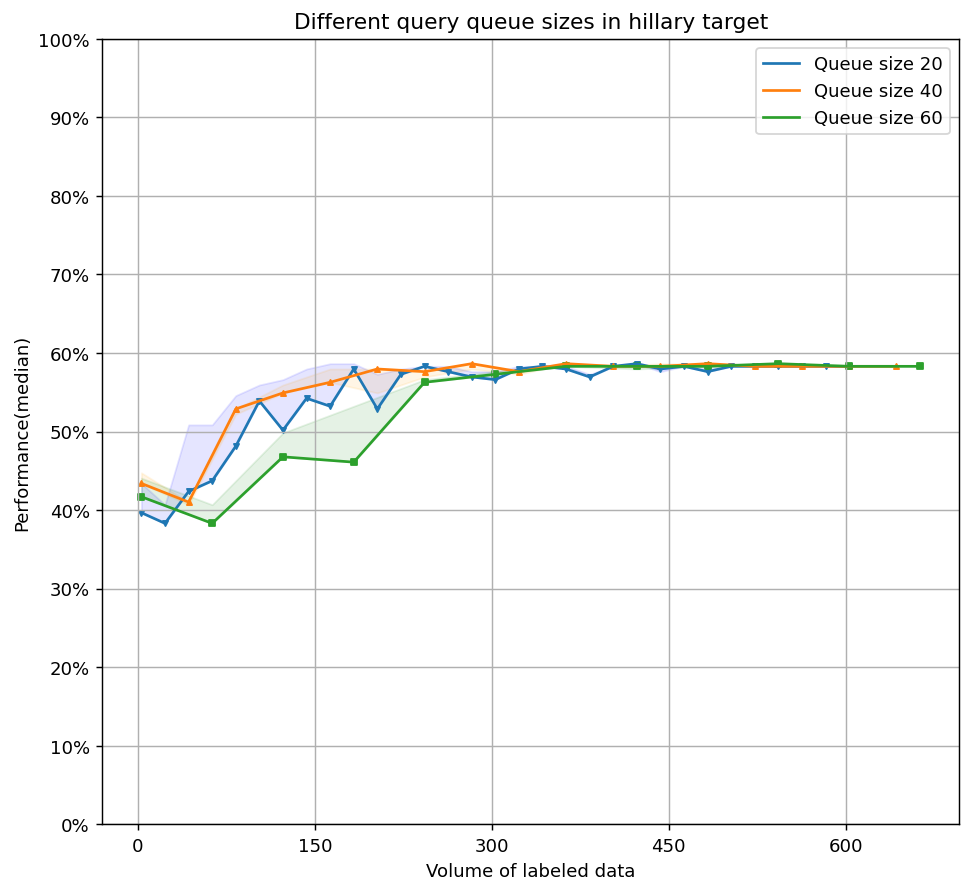

In [95]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(query_history_hillary1[0],median_hillary1,label="Queue size 20")
ax.fill_between(query_history_hillary1[0],min_hillary1,max_hillary1,color='blue', alpha=0.1)
ax.plot(query_history_hillary2[0],median_hillary2,label="Queue size 40")
ax.fill_between(query_history_hillary2[0],min_hillary2,max_hillary2,color='orange', alpha=0.1)
ax.plot(query_history_hillary3[0],median_hillary3,label="Queue size 60")
ax.fill_between(query_history_hillary3[0],min_hillary3,max_hillary3,color='green', alpha=0.1)

ax.scatter(query_history_hillary1[0], median_hillary1, s=8,marker = "v")
ax.scatter(query_history_hillary2[0], median_hillary2, s=8,marker="^")
ax.scatter(query_history_hillary3[0], median_hillary3, s=8,marker = ",")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different query queue sizes in hillary target')
ax.set_xlabel('Volume of labeled data')
ax.set_ylabel('Performance(median)')

plt.show()